**Table of contents**<a id='toc0_'></a>    
- 1. [Exchange economy with many consumers](#toc1_)    
  - 1.1. [Demand](#toc1_1_)    
  - 1.2. [Interactive figures](#toc1_2_)    
  - 1.3. [Equilibrium](#toc1_3_)    
- 2. [Numerical integration by Monte Carlo](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Random numbers example
=======

This notebook will show how to use random numbers to simulate and solve a full equilibrium model with many heterogeneous agents.

In [1]:
import numpy as np

from scipy.stats import norm # normal distribution

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

import ipywidgets as widgets

# 1. <a id='toc1_'></a>[Exchange economy with many consumers](#toc0_)

Consider an **exchange economy** with

1. 2 goods, $(x_1,x_2)$
2. $N$ consumers indexed by $j \in \{1,2,\dots,N\}$
3. Preferences are Cobb-Douglas with uniformly *heterogenous* coefficients

$$
\begin{aligned}
u^{j}(x_{1},x_{2}) & = x_{1}^{\alpha_{j}}x_{2}^{1-\alpha_{j}}\\
 & \,\,\,\alpha_{j}\sim\mathcal{U}(\underline{\mu},\overline{\mu})\\
 & \,\,\,0<\underline{\mu}<\overline{\mu}<1
\end{aligned}
$$

4. Endowments are *homogenous* and given by

$$
\boldsymbol{e}^{j}=(e_{1}^{j},e_{2}^{j})=(k,1),\,k>0
$$
where good 2 is *numeraire*.

The implied **demand functions** are:

$$
\begin{aligned}
x_{1}^{\star j}(p_{1},p_{2},e^{j})&=&\alpha_{j}\frac{I}{p_{1}}=\alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}} \\
x_{2}^{\star j}(p_{1},p_{2},e^{j})&=&(1-\alpha_{j})\frac{I}{p_{2}}=(1-\alpha_{j})\frac{kp_{1}+p_{2}}{p_{2}}
\end{aligned}
$$

The **equilibrium** for a random draw of $\alpha = \{\alpha_1,\alpha_2,\dots,\alpha_N\}$ is a set of **prices** $p_1$ and $p_2$ satifying:

$$
\begin{aligned}
x_1(p_1,p_2) = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^N e_1^j = Nk \\
x_2(p_1,p_2) = \sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) &= \sum_{j=1}^N e_2^j = N
\end{aligned}
$$

**Problem:** Solve for this equilibrium.  
But this requires a **distribution** of agents. Which means randomness.  
We need a random number generator (RNG)!

## 1.1. <a id='toc1_1_'></a>[Demand](#toc0_)

**Warm-up**: Choose parameters and define demand functions.

In [2]:
# a. parameters
N = 1000 # number of agents
k = 2 # relative endowment of good 1
mu_low = 0.1 # lower bound on alpha
mu_high = 0.9 # upper bound on alpha

# b. demand functions
def demand_good_1_func(alpha,p1,p2,k):
    I = k*p1+p2
    return alpha*I/p1

def demand_good_2_func(alpha,p1,p2,k):
    I = k*p1+p2
    return (1-alpha)*I/p2

**Quizz:** take a quick [quizz](https://forms.office.com/Pages/ResponsePage.aspx?id=kX-So6HNlkaviYyfHO_6kckJrnVYqJlJgGf8Jm3FvY9UMFpSRTIzUlJKMkdFQlpIN1VZUE9EVTBaMSQlQCN0PWcu) regarding the demand functions.

$$ 
x_1(p_1,p_2) = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) = \alpha_{j}\frac{kp_{1}+p_{2}}{p_{1}}
$$

Find demand distribution and total demand:

In [3]:
def find_demand_good_1(alphas,p1,p2,k):
    distr = demand_good_1_func(alphas,p1,p2,k) # Notice we are passing in arrays of alphas together with scalars! It works because of numpy broadcasting.
    total = distr.sum()
    return distr,total

Calculate for various prices:

In [4]:
# a. draw alphas
alphas = np.random.uniform(low=mu_low, high=mu_high, size=N)

# b. a set of hypothetical prices
p1_vec = [0.5,1,2,5]
p2 = 1

# c. calculate demand given
dists = np.empty((len(p1_vec),N))
totals = np.empty(len(p1_vec))
for i,p1 in enumerate(p1_vec):
    dist,total = find_demand_good_1(alphas,p1,p2,k)
    dists[i,:] = dist
    totals[i] = total

Plot the resulting demand given prices

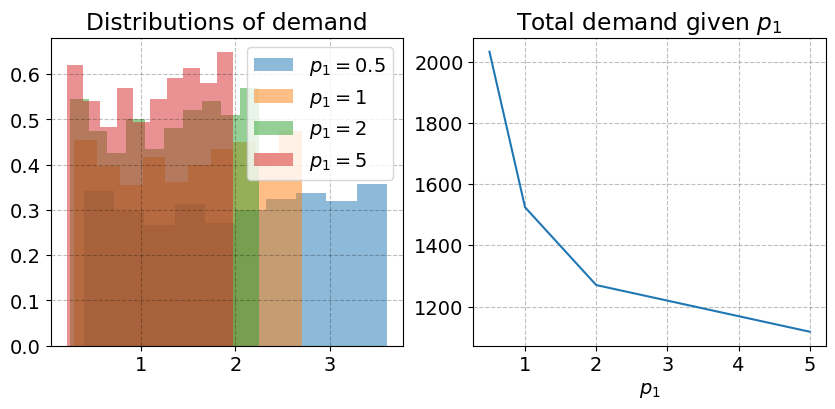

In [5]:
fig = plt.figure(figsize=(10,4))

ax_left = fig.add_subplot(1,2,1)
ax_left.set_title('Distributions of demand')
for i,p1 in enumerate(p1_vec):
    ax_left.hist(dists[i],density=True,alpha=0.5,label=f'$p_1 = {p1}$')
ax_left.legend(loc='upper right')

ax_right = fig.add_subplot(1,2,2)
ax_right.set_title('Total demand given $p_1$')
ax_right.grid(True)
ax_right.plot(p1_vec,totals)
ax_right.set_xlabel('$p_1$');

## 1.2. <a id='toc1_2_'></a>[Interactive figures](#toc0_)

Create a function constructing a figure:

In [6]:
# This function tells the widget how the plot should look at a specific parametrization 
def interactive_figure(alphas,p1,p2,k):
    
    # a. calculations
    dist,_total = find_demand_good_1(alphas,p1,p2,k)
    
    # b. figure
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.hist(dist,density=True)
    ax.set_xlim([0,4]) # fixed x range
    ax.set_ylim([0,0.8]) # fixed y range

**Case 1:** Make it interactive with a **slider**

In [7]:
# Write out which arguments to interactive_figure you want to be changing or staying fixed 
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description="$p_1$", min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatSlider(value=2.0, description='$p_1$', max=5.0, min=0.1, step=0.05), Output()), _do…

**Case 2:** Make it interactive with a **textbox**:

In [18]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatText(description=r"$p_1$", value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatText(value=2.0, description='$p_1$'), Output()), _dom_classes=('widget-interact',))

**Case 3:** Make it interactive with a **dropdown menu**

In [19]:
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.Dropdown(description="$p_1$", options=[0.5,1,1.5,2.0,2.5,3], value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(Dropdown(description='$p_1$', index=3, options=(0.5, 1, 1.5, 2.0, 2.5, 3), value=2.0), O…

**Task:** Add a slider for \\(k\\) to the interactive figure below.

In [10]:
# change this code
widgets.interact(interactive_figure,
    alphas=widgets.fixed(alphas),
    p1=widgets.FloatSlider(description="$p_1$", min=0.1, max=5, step=0.05, value=2),
    p2=widgets.fixed(p2),
    k=widgets.fixed(k)
);

interactive(children=(FloatSlider(value=2.0, description='$p_1$', max=5.0, min=0.1, step=0.05), Output()), _do…

## 1.3. <a id='toc1_3_'></a>[Equilibrium](#toc0_)

The equilibrium conditions were that **excess demand**, $Z$, is = 0 for both goods:

$$
\begin{aligned}
\sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) &= Nk \Leftrightarrow Z_1 \equiv \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - Nk = 0 \\
\sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) &= N \Leftrightarrow Z_2 \equiv \sum_{j=1}^N x_{2}^{\star j}(p_{1},p_{2},e^{j}) - N = 0
\end{aligned}
$$

**Idea:** Solve just the first equation. Then the second is satisfied due to Walras's law.

**Algorithm:**  
First choose a tolerance $\epsilon > 0$ and an adjustment factor $\kappa>0$, and a guess on $p_1 > 0$. 

Then find the equilibrium price by following iterative algorithm:

1. Calculate total excess demand of good 1: $Z_1 = \sum_{j=1}^N x_{1}^{\star j}(p_{1},p_{2},e^{j}) - Nk$
2. If $|Z_1| < \epsilon $ stop
3. If $|Z_1| \geq \epsilon $ set $p_1 = p_1 + \kappa \cdot \frac{Z_1}{N}$
4. Return to step 1

**Intuition**  
If excess demand is **positive** and far from 0, then **increase** the price.  
If excess demand is **negative** and far from 0, then **decrease** the price.  

In [11]:
# Use the functions in module market_eq
%load_ext autoreload 
%autoreload 2
from market_eq import * 

Finding the equilibrium price.  
See `market_eq.py` for implementation. 

In [12]:
p1_guess = 1.4
p2 = 1
kappa = 0.1
eps = 1e-8
p1 = find_equilibrium(alphas,p1_guess,p2,k,kappa=kappa,eps=eps)

  0: p1 =   1.33791452 -> excess demand ->  -620.85476613
  1: p1 =   1.27751323 -> excess demand ->  -604.01298351
  2: p1 =   1.21890752 -> excess demand ->  -586.05709322
  3: p1 =   1.16221412 -> excess demand ->  -566.93399705
  4: p1 =   1.10755415 -> excess demand ->  -546.59965887
   ...
 25: p1 =   0.54208913 -> excess demand ->   -56.07278067
 50: p1 =   0.51661764 -> excess demand ->    -0.32502672
 75: p1 =   0.51648015 -> excess demand ->    -0.00165171
100: p1 =   0.51647945 -> excess demand ->    -0.00000839
125: p1 =   0.51647945 -> excess demand ->    -0.00000004
132: p1 =   0.51647945 -> excess demand ->    -0.00000001


**Check:** Ensure that excess demand of both goods are (almost) zero.

In [13]:
Z1 = excess_demand_good_1_func(alphas,p1,p2,k)
Z2 = excess_demand_good_2_func(alphas,p1,p2,k)
print(Z1,Z2)
assert np.abs(Z1) < eps
assert np.abs(Z2) < eps

-9.703398973215371e-09 5.0116568672819994e-09


**Quizz:** take a quick quizz on the algorithm [here](https://forms.office.com/Pages/ResponsePage.aspx?id=kX-So6HNlkaviYyfHO_6kckJrnVYqJlJgGf8Jm3FvY9UMjRVRkEwQTRGVVJPVzRDS0dIV1VJWjhJVyQlQCN0PWcu)

# 2. <a id='toc2_'></a>[Numerical integration by Monte Carlo](#toc0_)

Numerical integration is the task of computing

$$ 
\mathbb{E}[\mathbf{g}(x)]  \text{ where } x \sim F,
$$

where $F$ is a known probability distribution and $\mathbf{g}(\cdot)$ is a function. In terms of a integral this can also be writen as

$$
\mathbb{E}[\mathbf{g}(x)] = \int_{x\in\mathcal{X}} \mathbf{g}(x) dF(x) = \int_{x\in\mathcal{X}} \mathbf{g}(x) f(x) dx
$$

where $f$ is the PDF for the CDF $F$ and $\mathcal{X}$ is the domain of $x$.

In an economic model, $\mathbf{g}$ might represent the way the state of an agent or the economy develops stochastically. 

Relying on the law of large numbers we **approximate** the true integral with a finite sample:

$$
\mathbb{E}[\mathbf{g}(x)] \approx \frac{1}{N}\sum_{i=1}^{N} \mathbf{g}(x_i) 
$$

where $x_i$ is drawn from $F$ using a random number generator. This is also called **numerical integration by Monte Carlo**.

For an easy implementation, we use  

$$
\mathbf{g}(x) = (x-2)^2
$$

**Monte Carlo function:**  

In [14]:
def g(x):
    return (x-2)**2

def MC(N,g,F):
    X = F.rvs(size=N) # rvs = draw N random values from F
    return np.mean(g(X)) # apply g to X

**Example** with a normal distribution:

In [15]:
N = 1000
mu = 0.1
sigma = 0.5
F = norm(loc=mu,scale=sigma)
mc_integral = MC(N,g,F)
print('E[g(x)] =', mc_integral)

E[g(x)] = 3.9692736744005024


Function for drawning $ K $ Monte Carlo samples:

In [16]:
def MC_sample(N,g,F,K):
    
    results = np.empty(K)
    for i in range(K):
        results[i] = MC(N,g,F)

    return results

The variance across Monte Carlo samples falls with larger $N$:

In [17]:
K = 1000
for N in [10**2,10**3,10**4,10**5]:
    results = MC_sample(N,g,F,K)
    print(f'N = {N:8d}: {results.mean():.6f} (std: {results.std():.4f})')

N =      100: 3.860277 (std: 0.1878)
N =     1000: 3.854060 (std: 0.0601)
N =    10000: 3.859868 (std: 0.0192)
N =   100000: 3.859829 (std: 0.0064)


In principle, you can always use Monte Carlo. But if $\mathbf{g}$ had been a very computationally costly function, Monte Carlo would be infeasible. But there are other ways, see the advanced random numbers notebook. 